In [1]:
pip list

Package                   Version
------------------------- -----------
absl-py                   2.3.1
altair                    6.0.0
asttokens                 3.0.1
astunparse                1.6.3
attrs                     25.4.0
blinker                   1.9.0
cachetools                6.2.3
certifi                   2025.11.12
charset-normalizer        3.4.4
click                     8.3.1
colorama                  0.4.6
comm                      0.2.3
contourpy                 1.3.2
cycler                    0.12.1
debugpy                   1.8.18
decorator                 5.2.1
exceptiongroup            1.3.1
executing                 2.2.1
flatbuffers               25.9.23
fonttools                 4.61.1
gast                      0.7.0
gitdb                     4.0.12
GitPython                 3.1.45
google-pasta              0.2.0
grpcio                    1.76.0
h5py                      3.15.1
idna                      3.11
ipykernel                 7.1.0
ipython           

In [2]:
import os
import json
from collections import Counter


In [3]:
def get_image_label(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    damage_list = []

    for feature in data['features']['xy']:
        props = feature['properties']
        if 'subtype' in props:
            damage_list.append(props['subtype'])

    if not damage_list:
        return 'Low'

    counts = Counter(damage_list)
    most_common = counts.most_common(1)[0][0]

    if most_common == 'no-damage':
        return 'Low'
    elif most_common == 'minor-damage':
        return 'Medium'
    else:
        return 'High'


In [4]:
import shutil

image_dir = "dataset/train/images"
label_dir = "dataset/train/labels"
output_dir = "processed_data"

os.makedirs(output_dir, exist_ok=True)
for cls in ['Low', 'Medium', 'High']:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

for file in os.listdir(image_dir):
    if file.endswith('.png'):
        image_path = os.path.join(image_dir, file)
        json_path = os.path.join(label_dir, file.replace('.png', '.json'))

        if os.path.exists(json_path):
            label = get_image_label(json_path)
            shutil.copy(image_path, os.path.join(output_dir, label, file))


In [5]:
for cls in ['Low', 'Medium', 'High']:
    print(cls, len(os.listdir(os.path.join(output_dir, cls))))


Low 1901
Medium 176
High 722


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [7]:
train_data = datagen.flow_from_directory(
    'processed_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    'processed_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 2240 images belonging to 3 classes.
Found 559 images belonging to 3 classes.


In [8]:
train_data.class_indices


{'High': 0, 'Low': 1, 'Medium': 2}

In [9]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Actual counts from your dataset
class_counts = {
    1: 1901,  # Low
    2: 176,   # Medium
    0: 722    # High
}

labels = []
for class_id, count in class_counts.items():
    labels.extend([class_id] * count)

labels = np.array(labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weight_dict = {
    0: class_weights[0],  # High
    1: class_weights[1],  # Low
    2: class_weights[2]   # Medium
}

class_weight_dict


{0: np.float64(1.2922437673130194),
 1: np.float64(0.4907943187795897),
 2: np.float64(5.301136363636363)}

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])


e:\disaster_prediction\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weight_dict
)


Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.3241 - loss: 1.7452 - val_accuracy: 0.1073 - val_loss: 1.1015
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.2277 - loss: 1.0990 - val_accuracy: 0.1020 - val_loss: 1.1178
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.1562 - loss: 1.0686 - val_accuracy: 0.0948 - val_loss: 1.1510
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.1848 - loss: 1.0710 - val_accuracy: 0.1038 - val_loss: 1.1530
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1960 - loss: 1.0297 - val_accuracy: 0.1199 - val_loss: 1.1849
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.2183 - loss: 1.0249 - val_accuracy: 0.1002 - val_loss: 1.1823
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.2313 - loss: 1.0107 - val_accuracy: 0.1503 - val_loss: 1.2187
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3214 - loss: 1.0063 - val_accuracy: 0.3864 - val_lo

In [18]:
model.save("disaster_damage_cnn_weighted.h5")


In [19]:
model.save("disaster_damage_cnn_weighted_k.keras")


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Get true labels and predictions from validation set
val_data.reset()
Y_true = val_data.classes
Y_pred = model.predict(val_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=list(val_data.class_indices.keys())))


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 759ms/step
Confusion Matrix:
 [[ 53  81  10]
 [109 238  33]
 [ 11  22   2]]
Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.37      0.33       144
         Low       0.70      0.63      0.66       380
      Medium       0.04      0.06      0.05        35

    accuracy                           0.52       559
   macro avg       0.35      0.35      0.35       559
weighted avg       0.56      0.52      0.54       559



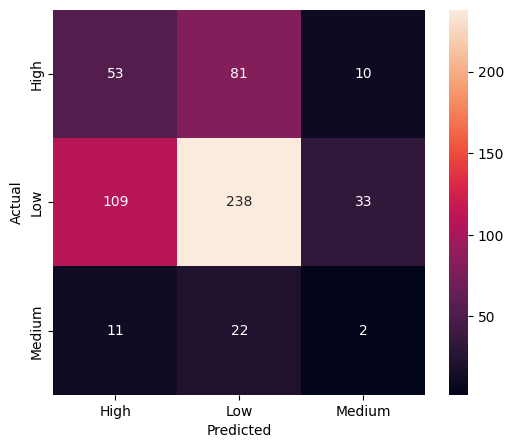

In [23]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [24]:
# Example: assign numeric risk
risk_mapping = {
    'Low': 0.2,
    'Medium': 0.5,
    'High': 1.0
}

pred_labels = [list(val_data.class_indices.keys())[i] for i in Y_pred_classes]
risk_scores = [risk_mapping[label] for label in pred_labels]


In [25]:
import pandas as pd

df_risk = pd.DataFrame({
    'image': val_data.filenames,
    'pred_class': pred_labels,
    'risk_score': risk_scores
})

df_risk.to_csv("validation_risk_scores_m1.csv", index=False)


* Pretrained model - ResNet50

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


In [3]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=output)


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 100s 1us/step


In [4]:
model_tl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
from tensorflow.keras.applications.resnet50 import preprocess_input


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [20]:
import os
import shutil
import random

base_dir = r"E:\disaster_prediction\processed_data"
output_dir = r"E:\disaster_prediction\processed_split"

train_dir = os.path.join(output_dir, "train")
val_dir   = os.path.join(output_dir, "val")

classes = ["High", "Low", "Medium"]

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

split_ratio = 0.8  # 80% train, 20% val

for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    split_idx = int(len(images) * split_ratio)
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(train_dir, cls, img)
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(val_dir, cls, img)
        )

print("✅ Train–Validation split completed.")


✅ Train–Validation split completed.


In [21]:
train_dir = r"E:\disaster_prediction\processed_split\train"
val_dir   = r"E:\disaster_prediction\processed_split\val"


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2237 images belonging to 3 classes.
Found 562 images belonging to 3 classes.


In [23]:
print(train_data.class_indices)


{'High': 0, 'Low': 1, 'Medium': 2}


In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


In [26]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=output)


In [27]:
model_tl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [28]:
history_tl = model_tl.fit(
    train_data,
    validation_data=val_data,
    epochs=8,
    class_weight=class_weight_dict
)


Epoch 1/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.4502 - loss: 1.4408 - val_accuracy: 0.5516 - val_loss: 0.8804
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.5190 - loss: 0.9741 - val_accuracy: 0.4929 - val_loss: 1.0059
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5463 - loss: 0.8980 - val_accuracy: 0.5907 - val_loss: 0.8461
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6026 - loss: 0.8528 - val_accuracy: 0.6068 - val_loss: 0.8538
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6187 - loss: 0.8163 - val_accuracy: 0.5552 - val_loss: 0.9019
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6397 - loss: 0.7671 - val_accuracy: 0.6228 - val_loss: 0.8032
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6227 - loss: 0.7768 - val_accuracy: 0.6406 - val_loss: 0.7583
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6500 - loss: 0.7635 - val_accuracy: 0.5996 - val_loss:

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [30]:
# Reset generator to start from first batch
val_data.reset()

# Predict probabilities
Y_pred = model_tl.predict(val_data)

# Convert probabilities to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)

# True labels
Y_true = val_data.classes


18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


In [31]:
cm = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[105  18  22]
 [ 74 209  98]
 [  9   4  23]]


In [32]:
class_names = list(val_data.class_indices.keys())

print(
    classification_report(
        Y_true,
        Y_pred_classes,
        target_names=class_names
    )
)


              precision    recall  f1-score   support

        High       0.56      0.72      0.63       145
         Low       0.90      0.55      0.68       381
      Medium       0.16      0.64      0.26        36

    accuracy                           0.60       562
   macro avg       0.54      0.64      0.52       562
weighted avg       0.77      0.60      0.64       562



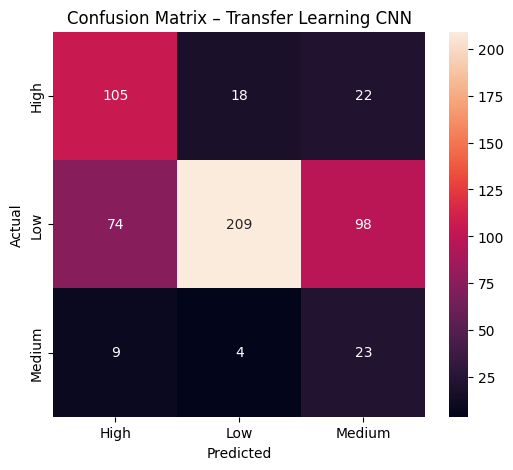

In [33]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Transfer Learning CNN")
plt.show()


In [34]:
model_tl.save("cnn_disaster_damage_resnet50.keras")


In [35]:
model_tl.save("cnn_disaster_damage_resnet50.h5")


In [36]:
from tensorflow.keras.models import load_model

cnn_model = load_model("cnn_disaster_damage_resnet50.keras")


In [37]:
print(train_data.class_indices)


{'High': 0, 'Low': 1, 'Medium': 2}


In [38]:
risk_map = {
    0: 1.0,   # High
    1: 0.2,   # Low
    2: 0.6    # Medium
}


In [39]:
import numpy as np

val_data.reset()

probs = cnn_model.predict(val_data)
pred_classes = np.argmax(probs, axis=1)

risk_scores = np.array([risk_map[c] for c in pred_classes])


18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


In [40]:
print("Sample risk scores:", risk_scores[:10])
print("Min risk:", risk_scores.min())
print("Max risk:", risk_scores.max())


Sample risk scores: [0.6 1.  1.  1.  1.  1.  1.  1.  1.  1. ]
Min risk: 0.2
Max risk: 1.0


In [41]:
import numpy as np

def create_sequences(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [42]:
window_size = 3

X_seq, y_seq = create_sequences(risk_scores, window_size)

print("X shape:", X_seq.shape)
print("y shape:", y_seq.shape)


X shape: (559, 3)
y shape: (559,)


In [43]:
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))


In [44]:
split = int(0.8 * len(X_seq))

X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])


e:\disaster_prediction\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
lstm_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


In [47]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16
)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2397 - mae: 0.3900 - val_loss: 0.1287 - val_mae: 0.3073
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1035 - mae: 0.2703 - val_loss: 0.1227 - val_mae: 0.2995
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0965 - mae: 0.2652 - val_loss: 0.1235 - val_mae: 0.3011
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0978 - mae: 0.2696 - val_loss: 0.1255 - val_mae: 0.3038
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0976 - mae: 0.2674 - val_loss: 0.1263 - val_mae: 0.3057
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0950 - mae: 0.2638 - val_loss: 0.1275 - val_mae: 0.3088
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0956 - mae: 0.2626 - val_loss: 0.1216 - val_mae: 0.2960
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0984 - mae: 0.2671 - val_loss: 0.1281 - val_mae: 0.3097
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0970 - mae:

In [48]:
loss, mae = lstm_model.evaluate(X_val, y_val)
print("Validation MAE:", mae)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1206 - mae: 0.2972  
Validation MAE: 0.29718858003616333


In [49]:
def allocate_resources(predicted_risk):
    if predicted_risk >= 0.8:
        return {
            "risk_level": "Severe",
            "deploy": ["NDRF", "Medical Teams", "Temporary Shelters"],
            "priority": "Immediate"
        }
    elif predicted_risk >= 0.5:
        return {
            "risk_level": "Moderate",
            "deploy": ["Medical Teams", "Food & Water"],
            "priority": "High"
        }
    else:
        return {
            "risk_level": "Low",
            "deploy": ["Monitoring"],
            "priority": "Normal"
        }


In [50]:
# Take last observed sequence
last_sequence = X_seq[-1].reshape(1, window_size, 1)

future_risk = lstm_model.predict(last_sequence)[0][0]

decision = allocate_resources(future_risk)

print("Predicted Future Risk:", future_risk)
print("Decision:", decision)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Predicted Future Risk: 0.4242342
Decision: {'risk_level': 'Low', 'deploy': ['Monitoring'], 'priority': 'Normal'}


In [51]:
lstm_model.save("lstm_risk_model.keras")


In [52]:
lstm_model.save("lstm_risk_model.h5")
